# IMPORTS

In [1]:
import pandas as pd
from typing import Dict, List
from collections import Counter
from pprint import pprint
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
sns.set()

# Data reading 

In [2]:
path1="/home/redha/Documents/projects/NLP/datamining project/Soil-Fertility/data/Dataset1.csv"
path2="/home/redha/Documents/projects/NLP/datamining project/Soil-Fertility/data/Dataset2.csv"
path3="/home/redha/Documents/projects/NLP/datamining project/Soil-Fertility/data/Dataset3.xlsx"

In [3]:
df=pd.read_csv(path1)

# Data Manipulation 

## Data Cleaning

In [4]:
# print description of dataset , number of rows and columns , type of each column , number of null values , number of unique values 
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 885 entries, 0 to 884
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   N          885 non-null    int64  
 1   P          885 non-null    object 
 2   K          885 non-null    int64  
 3   pH         885 non-null    float64
 4   EC         885 non-null    float64
 5   OC         884 non-null    float64
 6   S          885 non-null    float64
 7   Zn         885 non-null    float64
 8   Fe         885 non-null    float64
 9   Cu         884 non-null    float64
 10  Mn         885 non-null    float64
 11  B          885 non-null    float64
 12  OM         885 non-null    float64
 13  Fertility  885 non-null    int64  
dtypes: float64(10), int64(3), object(1)
memory usage: 96.9+ KB
None


we see the type of P column is object, we need to convert it to numeric

In [5]:
# let's check if there is any weird values in the dataset
for col in df.columns :
    try : 
        df[col].astype(float)
    except Exception as e :
        print(f"{col} : {e}")

P : could not convert string to float: '?'


In [6]:
def drop_rows_with_value(df : pd.DataFrame, value_to_drop : List[str | int | float | None] ) -> pd.DataFrame:
    """
    Drops rows in a DataFrame where a specified value is found.

    Parameters:
    - df: pandas DataFrame
    - value_to_drop: the value to drop from the specified column

    Returns:
    - Modified DataFrame with rows containing the specified value dropped
    """
    none_values = [
    "",
    " ",
    "nan",
    "NaN",
    "Nan",
    "NAN",
    "None",
    "none",
    "NONE",
    "null",
    "Null",
    "NULL",
    "?",
    "NA",
    "na",
    "Na",
    "nA",
    None,
    np.nan
]
    new_df=df.copy()
    empty_values = none_values+ value_to_drop
    
    for col in new_df.columns:
        if pd.api.types.is_numeric_dtype(new_df[col]):
            # Handle numeric columns, including NaN
            new_df = new_df[new_df[col].notna() & ~new_df[col].isin(empty_values)]
        else:
            # Handle non-numeric columns
            new_df = new_df[~new_df[col].astype(str).str.lower().isin(empty_values)]

    return new_df



In [7]:
df=drop_rows_with_value(df,['?'])

In [8]:
df['P']=df['P'].astype(float)

The data contain some null values so we have to deal with them before we can start our analysis.

In [9]:
df['OC'].isnull().sum()

0

remove duplicates

In [10]:
def drop_duplicates(df : pd.DataFrame) -> pd.DataFrame :
    """ drop duplicates rows in the dataset

    Args:
        df (pd.DataFrame): dataframe to drop duplicates from

    Returns:
        pd.DataFrame: dataframe without duplicates
    """
    new_df=df.copy()
    dataframe_rows = []

    for _, row in new_df.iterrows():
        row_tuple = tuple(row)
        dataframe_rows.append(row_tuple)

    dropped_set = set(dataframe_rows)

    unique_rows = [list(row_tuple) for row_tuple in dropped_set]

    unique_df = pd.DataFrame(unique_rows, columns=new_df.columns)
    return unique_df

In [11]:
df=drop_duplicates(df)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878 entries, 0 to 877
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   N          878 non-null    float64
 1   P          878 non-null    float64
 2   K          878 non-null    float64
 3   pH         878 non-null    float64
 4   EC         878 non-null    float64
 5   OC         878 non-null    float64
 6   S          878 non-null    float64
 7   Zn         878 non-null    float64
 8   Fe         878 non-null    float64
 9   Cu         878 non-null    float64
 10  Mn         878 non-null    float64
 11  B          878 non-null    float64
 12  OM         878 non-null    float64
 13  Fertility  878 non-null    float64
dtypes: float64(14)
memory usage: 96.2 KB


## Data Visualization

In [13]:
def calculate_central_tendencies(df : pd.DataFrame) -> Dict[str,Dict[str,float]]:
    """this function calculate the central tendencies : mean , median , mode , min , max of each column in the dataframe
    Args:
        df (pd.Dataframe): pandas dataframe to calculate the central tendencies

    Returns:
        Dict: dictionary of the central tendencies of each column
    """
    tendencies={}
    new_df=df.copy()

    for column in new_df.columns:
        flag=False
        if new_df[column].dtype=='object' or new_df[column].dtype=='string':
            tendencies[column] = {'min': None, 'max': None, 'mean': None, 'median': None, 'mode': None, 'std': None}
        else:
            if new_df[column].dtype=='datetime64[ns]':
                flag=True
                new_df[column]=new_df[column].astype(np.int64)
                
            #calculate mean 
            col_len=len(new_df[column])
            mean=sum(new_df[column])/col_len

            #calculate median
            sorted_column=sorted(new_df[column])
            if col_len%2==0:
                median1 = sorted_column[col_len//2]
                median2 = sorted_column[col_len//2-1]
                median=(median1+median2)/2
            else:
                median=sorted_column[col_len//2]

            #calculate mode
            counter = Counter(new_df[column])
            mode = counter.most_common(1)[0][0] 

            #calculate min    
            minimum=sorted_column[0]

            #calculate max
            maximum=sorted_column[-1]

            #calculate standard deviation
            std=0
            for data in new_df[column]:
                std+=((data-mean)**2)
            std=std/col_len
            std=std**0.5

            if df[column].dtype=='datetime64[ns]':
                mean, median, mode, minimum, maximum, std = pd.to_datetime([mean, median, mode, minimum, maximum, std])
                flag=False

            tendencies[column]={'min':minimum,'max':maximum,'mean':mean,'median':median,'mode':mode,'std':std}
            
    return tendencies

In [14]:
tendencies=calculate_central_tendencies(df)
pprint(tendencies)

{'B': {'max': 2.82,
       'mean': 0.5861389521640087,
       'median': 0.4,
       'min': 0.06,
       'mode': 0.34,
       'std': 0.5642078841180364},
 'Cu': {'max': 3.02,
        'mean': 0.9516970387243736,
        'median': 0.93,
        'min': 0.09,
        'mode': 1.25,
        'std': 0.4660293324871125},
 'EC': {'max': 0.95,
        'mean': 0.5440774487471528,
        'median': 0.55,
        'min': 0.1,
        'mode': 0.62,
        'std': 0.14148256142084017},
 'Fe': {'max': 44.0,
        'mean': 4.145763097949893,
        'median': 3.565,
        'min': 0.21,
        'mode': 6.32,
        'std': 3.1060821807147145},
 'Fertility': {'max': 2.0,
               'mean': 0.5876993166287016,
               'median': 1.0,
               'min': 0.0,
               'mode': 1.0,
               'std': 0.5734711800322215},
 'K': {'max': 1560.0,
       'mean': 501.04214123006835,
       'median': 475.0,
       'min': 11.0,
       'mode': 444.0,
       'std': 129.02722356160547},
 'Mn': {'ma

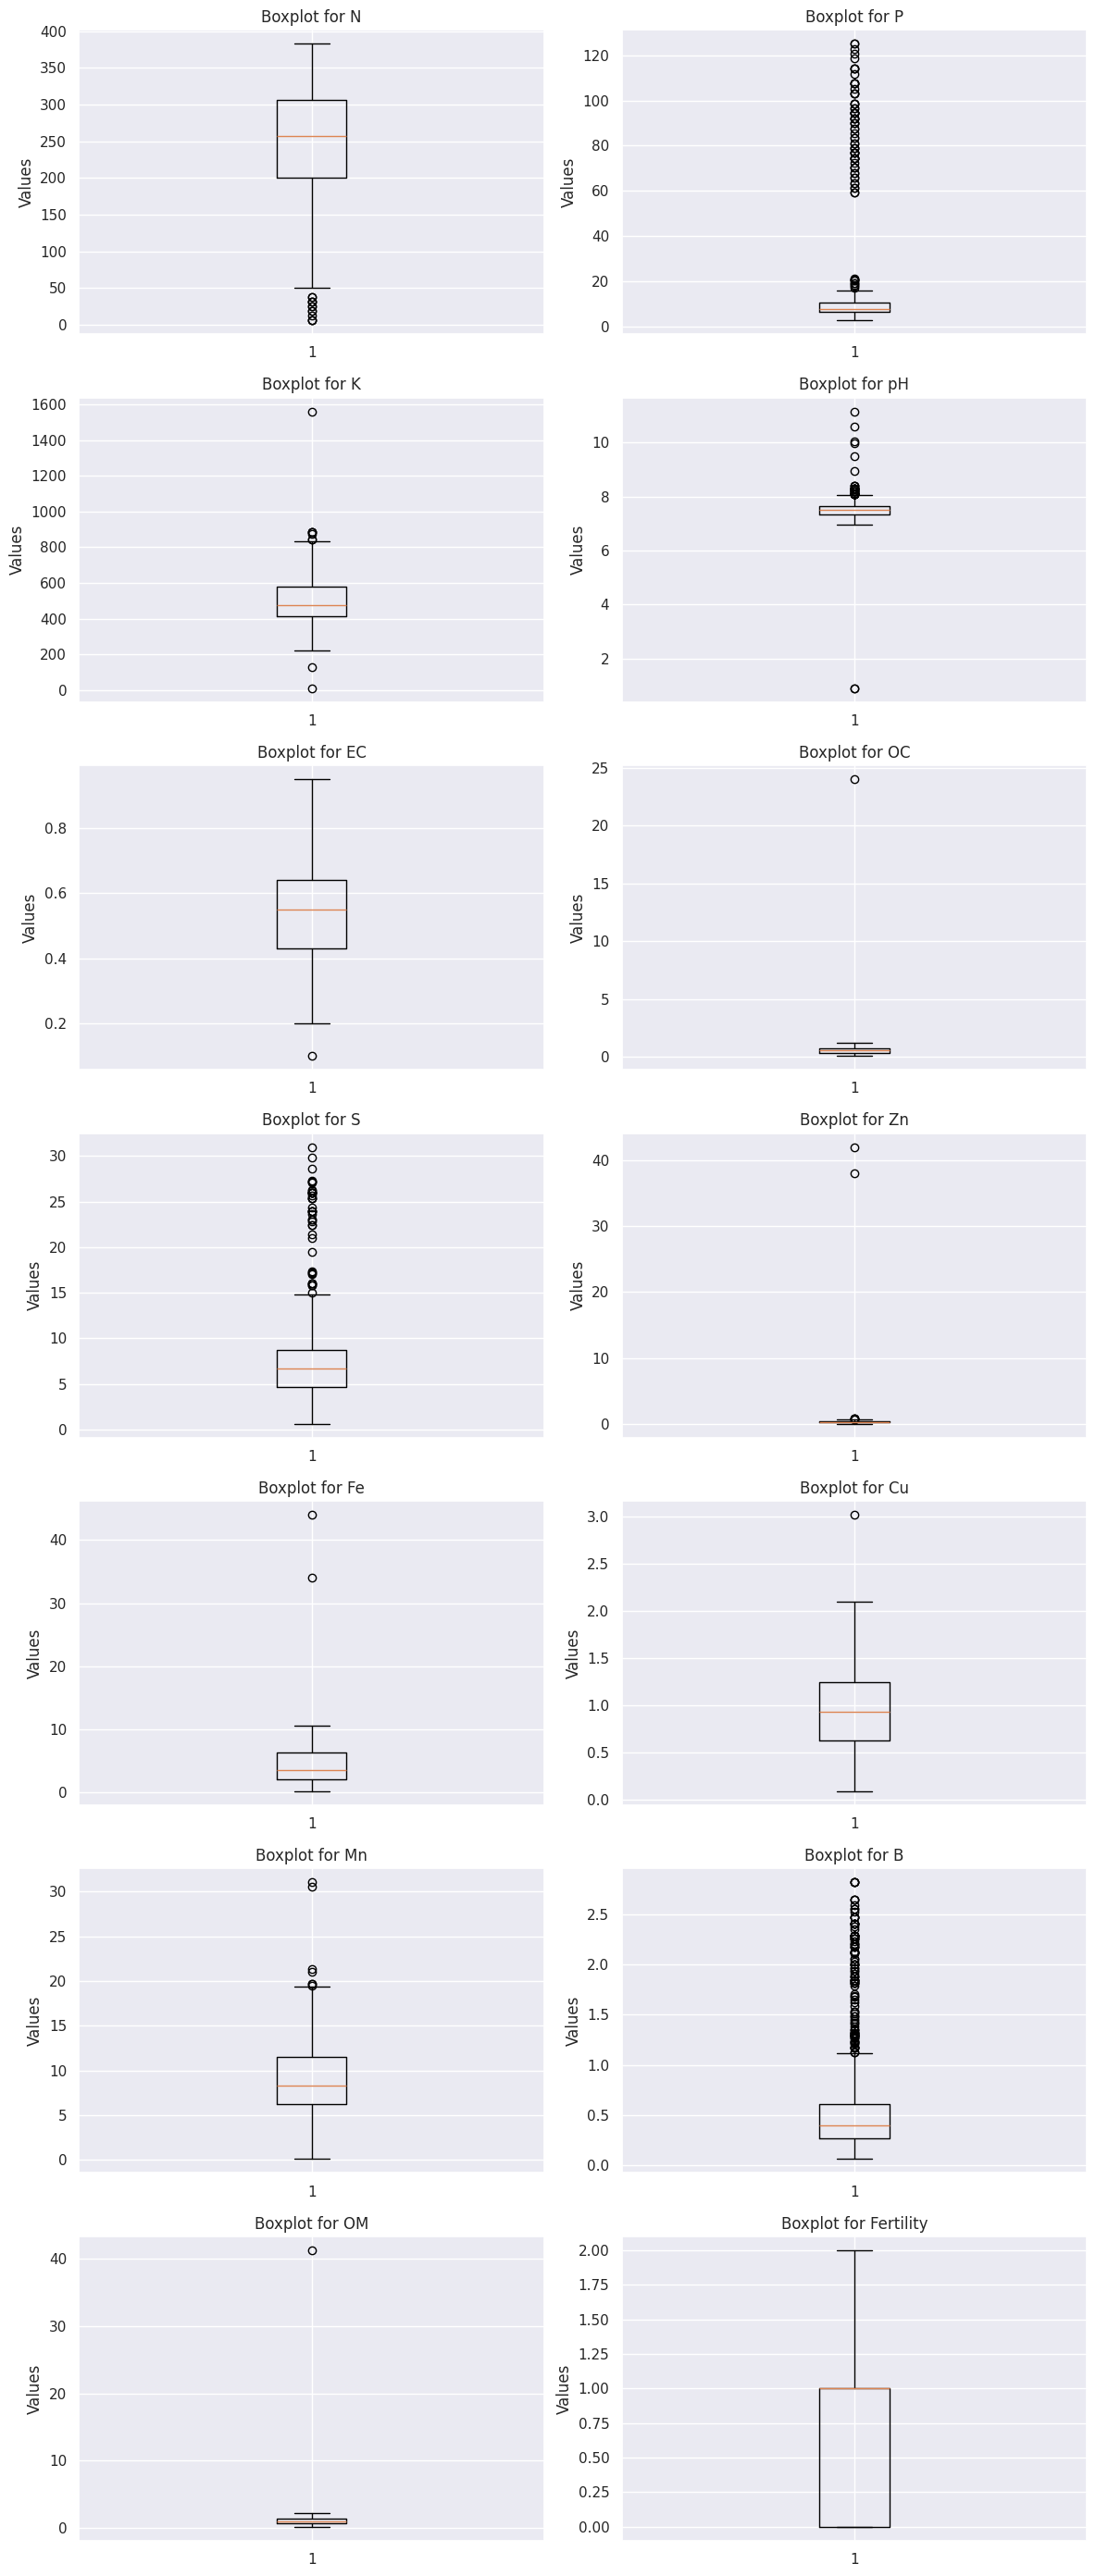

In [15]:
num_columns = len(df.columns)
plot_per_row = 2
num_rows = num_columns // plot_per_row + (num_columns % plot_per_row > 0)

plt.figure(figsize=(12, num_rows * 4))
for i, col in enumerate(df.columns):
    plt.subplot(num_rows, plot_per_row, i + 1)

    try:
        plt.boxplot(df[col]) 
        plt.ylabel("Values")
        plt.title(f'Boxplot for {col}')
    except:
        plt.ylabel("Values")
        plt.title(f'Boxplot for {col}')
        pass

plt.tight_layout()
plt.show()

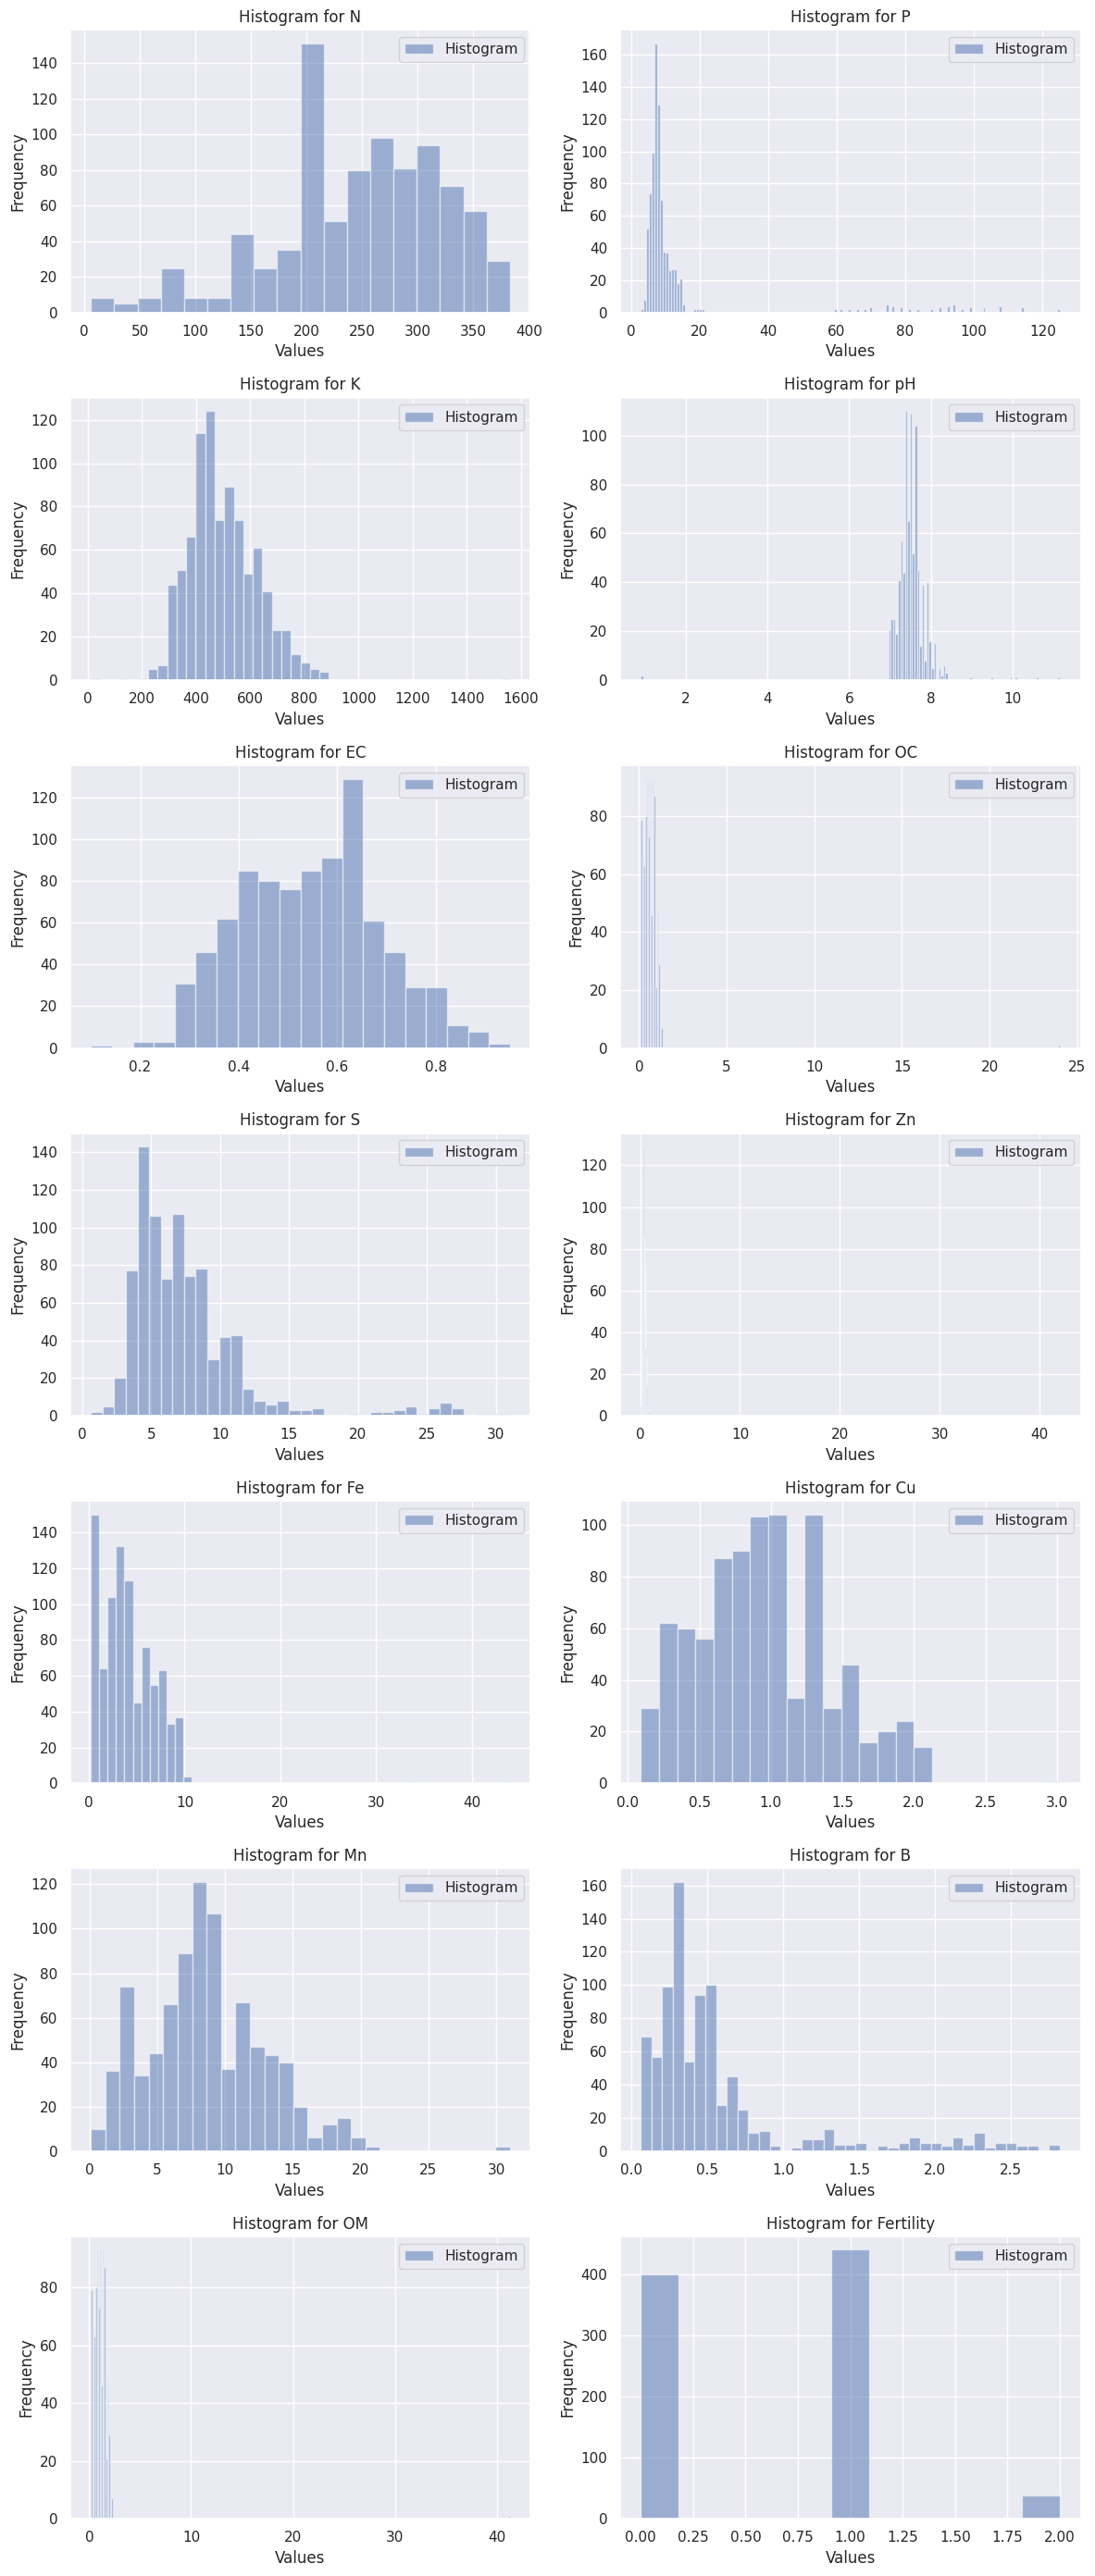

In [16]:
num_columns = len(df.columns)
plot_per_row = 2
num_rows = num_columns // plot_per_row + (num_columns % plot_per_row > 0)

plt.figure(figsize=(12, num_rows * 4))

for i, col in enumerate(df.columns):
    plt.subplot(num_rows, plot_per_row, i + 1)

    try:
        plt.hist(df[col], alpha=0.5, bins='auto', label='Histogram')
        plt.ylabel("Frequency")
        plt.xlabel("Values")
        plt.title(f'Histogram for {col}')
        plt.legend()
    except:
        plt.ylabel("Frequency")
        plt.xlabel("Values")
        plt.title(f'Histogram for {col}')
        pass

plt.tight_layout()
plt.show()

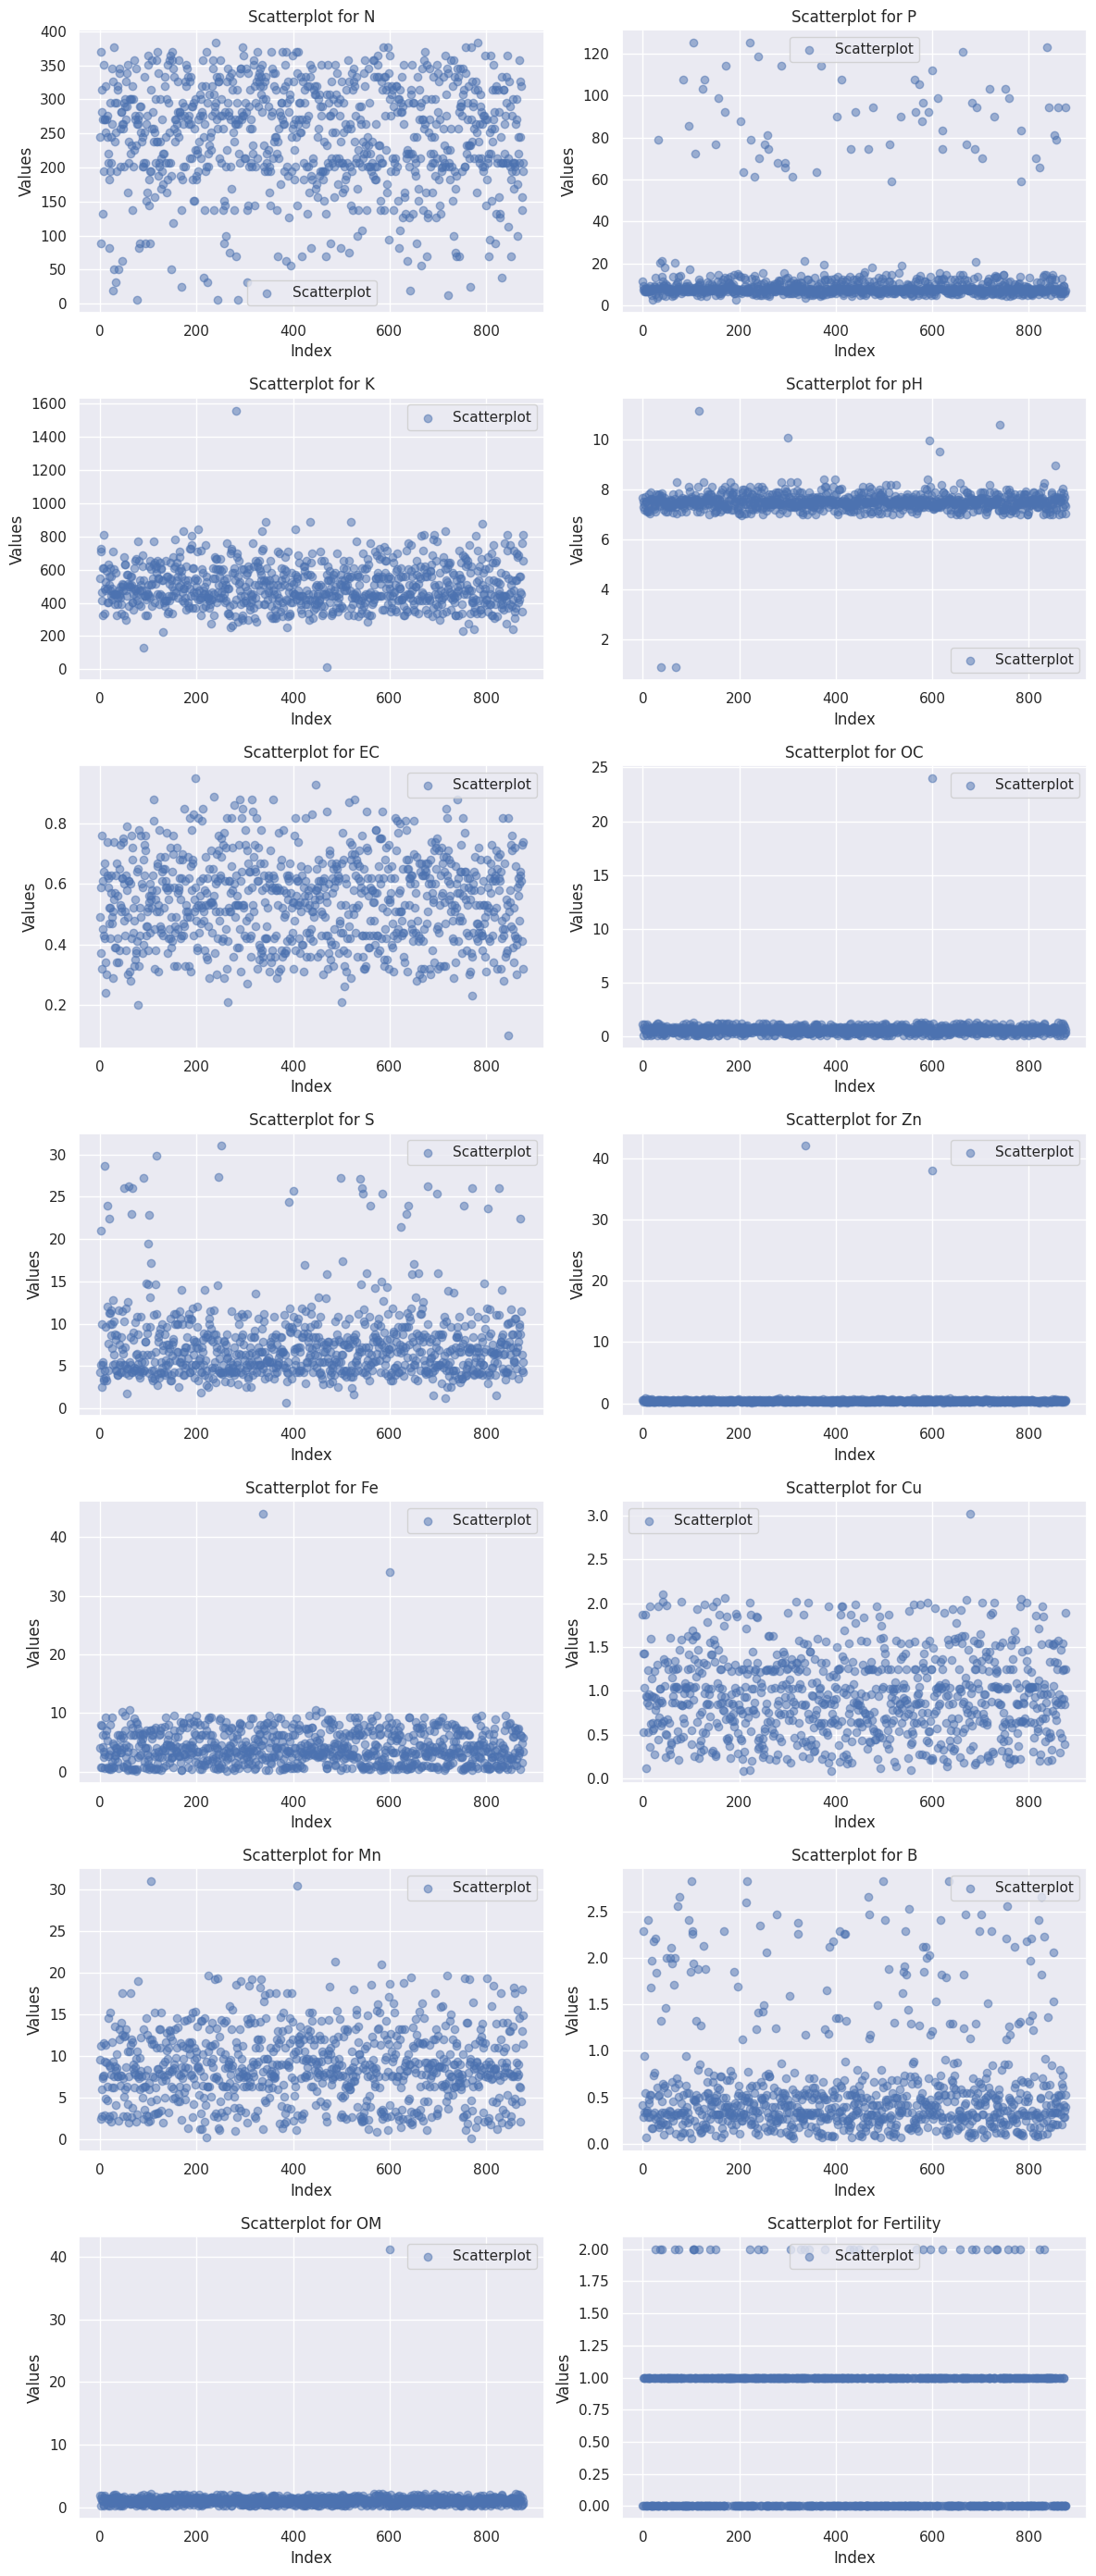

In [17]:
num_columns = len(df.columns)
plot_per_row = 2
num_rows = num_columns // plot_per_row + (num_columns % plot_per_row > 0)

plt.figure(figsize=(12, num_rows * 4))

for i, col in enumerate(df.columns):
    plt.subplot(num_rows, plot_per_row, i + 1)

    try:
        plt.scatter(range(len(df[col])), df[col], alpha=0.5, label='Scatterplot')
        plt.ylabel("Values")
        plt.xlabel("Index")
        plt.title(f'Scatterplot for {col}')
        plt.legend()
    except:
        plt.ylabel("Values")
        plt.xlabel("Index")
        plt.title(f'Scatterplot for {col}')
        pass

plt.tight_layout()
plt.show()

In [18]:
df.dropna(inplace=True)

In [19]:
def quartiles(df : pd.DataFrame, percentiles : list) -> Dict[str,List[float]] :
    """ this function calculate the quartiles of each column in the dataframe

    Args:
        df (pd.DataFrame): the dataframe to calculate the quartiles
        percentiles (List): list of the percentiles to calculate

    Returns:
        Dict[str,Dict[str,float]]: dictionary of the quartiles of each column
    """
    new_df=df.copy()
    quartiles_dict = {}

    for percentile in percentiles:
        if not (0 <= percentile <= 1):
            raise ValueError("Percentile must be between 0 and 1")

    indexes = [(int(percentile * len(new_df)),percentile) for percentile in percentiles]

    for col in new_df.columns:
        col_quartiles=[]
        sorted_column = sorted(new_df[col])
        for index,percentile in indexes :
            if percentile == 0 :
                tendencies=calculate_central_tendencies(new_df)[col]
                col_quartiles.append(tendencies.get('min'))
            elif percentile == 1 :
                col_quartiles.append(tendencies.get('max'))
            else :
                col_quartiles.append(sorted_column[index])
        quartiles_dict[col] = col_quartiles

    return quartiles_dict


In [20]:
quartiles_dict = quartiles(df,[0,0.25,0.5,0.75,1])
pprint(quartiles_dict)

{'B': [0.06, 0.27, 0.4, 0.61, 2.82],
 'Cu': [0.09, 0.63, 0.93, 1.25, 3.02],
 'EC': [0.1, 0.43, 0.55, 0.64, 0.95],
 'Fe': [0.21, 2.06, 3.57, 6.32, 44.0],
 'Fertility': [0.0, 0.0, 1.0, 1.0, 2.0],
 'K': [11.0, 412.0, 475.0, 581.0, 1560.0],
 'Mn': [0.11, 6.23, 8.37, 11.48, 31.0],
 'N': [6.0, 201.0, 257.0, 307.0, 383.0],
 'OC': [0.1, 0.38, 0.59, 0.78, 24.0],
 'OM': [0.172, 0.6536, 1.0148, 1.3416, 41.28],
 'P': [2.9, 6.8, 8.1, 10.7, 125.0],
 'S': [0.64, 4.7, 6.64, 8.75, 31.0],
 'Zn': [0.07, 0.28, 0.36, 0.47, 42.0],
 'pH': [0.9, 7.35, 7.5, 7.63, 11.15]}


In [21]:
def find_outliers(df : pd.DataFrame, show : bool = False) -> pd.DataFrame:
    """ Drops outliers from a DataFrame using the IQR method.

    Args:
        df (pd.Dataframe): the dataset to drop outliers from
    
    Returns:
        pd.Dataframe: the dataset without outliers
    """
    new_df=df.copy()

    quartiles_dict = quartiles(new_df, [0, 0.25, 0.5, 0.75, 1])

    for col in new_df.columns:
        q1, q3 = quartiles_dict[col][1], quartiles_dict[col][3]
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr

        if show:
            print(f"Column {col} : lower bound = {lower_bound} , upper bound = {upper_bound}")
            print(f"Outliers : {new_df[(new_df[col] < lower_bound) | (new_df[col] > upper_bound)][col]}")

        new_df = new_df[(new_df[col] >= lower_bound) & (new_df[col] <= upper_bound)]

    return new_df

def drop_outliers(df : pd.DataFrame, show : bool = False) -> pd.DataFrame:
    """ drop outliers until data stabilizes

    Args:
        df (pd.DataFrame): the dataframe to drop outliers from

    Returns:
        pd.DataFrame: the dataframe without outliers
    """
    new_df=df.copy()
    while True:
        df_without_outliers = find_outliers(new_df,show)
        if len(df_without_outliers) == len(new_df):
            return df_without_outliers
        new_df = df_without_outliers

In [22]:
df=drop_outliers(df)

In [23]:
df.shape

(492, 14)

# normalization de données

## MinMax Method

minmax scaler = find the min and max of each column and then apply the formula to normalize the data

the formula is : (x - min) / (max - min)

In [24]:
def MinMaxTransformer(df : pd.DataFrame) -> pd.DataFrame:
    """ MinMaxTransformer function to normalize the data

    Args:
        df (pd.DataFrame): the dataframe to normalize

    Returns:
        pd.DataFrame: the normalized dataframe
    """
    new_df=df.copy()
    infos=calculate_central_tendencies(new_df)
    for col in new_df.columns:
        max=infos[col].get('max')
        min=infos[col].get('min')
        diff=max-min
        x_diff=new_df[col]-min
        new_val=x_diff/diff
        new_df[col]=new_val
    return new_df

z score normalization = find the mean and the standard deviation of each column and then apply the formula to normalize the data

formula : (x - mean) / std

In [25]:
def ZScoreTransformer(df : pd.DataFrame) -> pd.DataFrame:
    """this function normalize the data using the zscore method

    Args:
        df (pd.DataFrame): the dataframe to normalize

    Returns:
        pd.DataFrame: dataframe normalized
    """

    new_df=df.copy()
    infos=calculate_central_tendencies(new_df)
    
    for col in new_df.columns:
        mean=infos[col].get('mean')
        std=infos[col].get('std')
        new_df[col]=(new_df[col]-mean)/std
    
    return new_df
    